# Basic classification using the SparseCVIGaussianProcess model

This notebook explains how to perform GP inference using the Markovflow CVIGaussianProcess model.
Here, we perform binary classification with time as the input.

As with GPR, the observations do not have to be regularly spaced. However, they do need to be sequential. We denote the input/output tuples as $(x_i, y_i)_{1 \leq i \leq n}$, where $x_i$ is a scalar value and $y_i \in \{0, 1\}$.

Our probabilistic model for this data is:
$$
\begin{align}
f \sim \mathcal{GP}(0, k(., .)) \\
y_i \sim \mathcal{B}(\Phi(f(x_i)))
\end{align}
$$

where $\Phi$ is a function that maps $f(x_i)$ to $[0, 1]$, the probability that $y_i=1$. In practice, we choose $\Phi$ to be the standard normal cumulative distribution function (also known as the probit function) which maps to $[0, 1]$.

**NOTE:** If you have difficulty running this notebook, consider clearing the output and then restarting the kernel.

In [1]:
# Setup

import warnings

# Turn off warnings
warnings.simplefilter('ignore')


import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from gpflow import default_float
from gpflow.ci_utils import ci_niter
from gpflow.likelihoods import Bernoulli

from markovflow.models.sparse_variational_cvi import SparseCVIGaussianProcess
from markovflow.kernels import Matern52


np.random.seed(0)
FLOAT_TYPE = default_float()

# uncomment in notebook
# try:
#     from IPython import get_ipython
#     get_ipython().run_line_magic('matplotlib', 'inline')
# except AttributeError:
#     print('Magic function can only be used in IPython environment')
#     matplotlib.use('Agg')

plt.rcParams["figure.figsize"] = [15, 8]

2022-09-17 14:52:21.261693: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/hostedtoolcache/Python/3.7.13/x64/lib
2022-09-17 14:52:21.261726: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Step 1: Generate training data

First, let's generate some binary data $X = (x_1, \dots, x_n)$ and $Y = (y_1, \dots, y_n)^T$.

In [2]:
# Generate some observations
num_data  = 300
num_inducing = 30

time_points = np.linspace(0 , 1, num_data)
inducing_points = np.linspace(0 , 1, num_inducing)
F = np.cos(time_points * 20).reshape(-1, 1)
observations = (F + np.random.randn(*F.shape) > 0).astype(float)
data = (time_points, observations)

## Step 2: Choose a kernel

In [3]:

kernel = Matern52(lengthscale=.2, variance=5.0)

# We see Matern12 has only two dimensions (therefore there is less risk of overparameterising)
print(kernel.state_dim)

3


2022-09-17 14:52:22.744997: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-09-17 14:52:22.745181: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/hostedtoolcache/Python/3.7.13/x64/lib
2022-09-17 14:52:22.745193: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-17 14:52:22.745212: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fv-az178-774): /proc/driver/nvidia/version does not exist
2022-09-17 14:52:22.745470: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F F

## Step 3: Build and optimise a model

This is a classification problem with outputs between `[0,1]`, so we create a variational GP model using a Bernoulli likelihood.

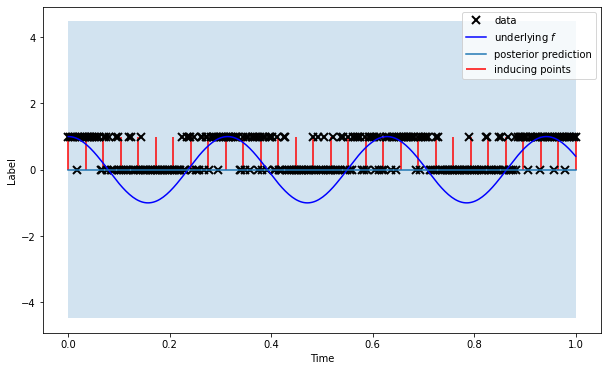

0 tf.Tensor(-517.8577608092692, shape=(), dtype=float64)


20 tf.Tensor(-171.52080807503216, shape=(), dtype=float64)


40 tf.Tensor(-171.46704535187882, shape=(), dtype=float64)


60 tf.Tensor(-171.4661794781078, shape=(), dtype=float64)


80 tf.Tensor(-171.46616074225687, shape=(), dtype=float64)


100 tf.Tensor(-171.46616026901006, shape=(), dtype=float64)


120 tf.Tensor(-171.46616025591766, shape=(), dtype=float64)


140 tf.Tensor(-171.4661602555351, shape=(), dtype=float64)


160 tf.Tensor(-171.46616025552538, shape=(), dtype=float64)


180 tf.Tensor(-171.4661602555217, shape=(), dtype=float64)


200 tf.Tensor(-171.46616025552393, shape=(), dtype=float64)


220 tf.Tensor(-171.46616025552476, shape=(), dtype=float64)


240 tf.Tensor(-171.4661602555242, shape=(), dtype=float64)


260 tf.Tensor(-171.46616025552322, shape=(), dtype=float64)


280 tf.Tensor(-171.46616025552422, shape=(), dtype=float64)


300 tf.Tensor(-171.46616025552356, shape=(), dtype=float64)


320 tf.Tensor(-171.46616025552288, shape=(), dtype=float64)


340 tf.Tensor(-171.4661602555239, shape=(), dtype=float64)


360 tf.Tensor(-171.4661602555263, shape=(), dtype=float64)


380 tf.Tensor(-171.46616025552328, shape=(), dtype=float64)


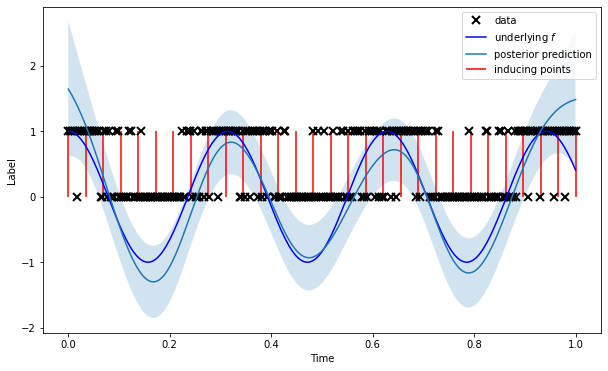

In [4]:

# Create a likelihood object
likelihood = Bernoulli()

scvi = SparseCVIGaussianProcess(kernel=kernel,
                          inducing_points=tf.constant(inducing_points),
                          likelihood=likelihood,
                          learning_rate=.1)


def plot_model(model):

    f_mu, f_var = model.posterior.predict_f(time_points)
    f_mu = f_mu.numpy()
    f_std = np.sqrt(f_var)

    plt.figure(figsize=(10, 6))
    plt.vlines(inducing_points,
               ymin=observations.min(), ymax=observations.max(),
               color='r', label='inducing points')
    plt.plot(time_points, observations, 'kx', ms=8, mew=2, label='data')
    plt.plot(time_points, F, 'b', ms=8, mew=2, label='underlying $f$')
    plt.plot(time_points, f_mu, 'C0', ms=8, mew=2, label='posterior prediction')
    plt.fill_between(
        time_points,
        y1 = (f_mu - 2 * f_std).reshape(-1,),
        y2 = (f_mu + 2 * f_std).reshape(-1,),
        alpha=.2, facecolor='C0'
    )
    plt.xlabel("Time")
    plt.ylabel("Label")
    plt.legend()
    plt.show()


plot_model(scvi)

max_iter = ci_niter(400)
for i in range(max_iter):
    if i % 20 == 0:
        print(i, scvi.classic_elbo(data))
    scvi.update_sites(data)
plot_model(scvi)